<a href="https://colab.research.google.com/github/Bruno-GSilva/price-prediction/blob/main/model_2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2

### Mount Drive to access data

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.functional import F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data Loader

In [114]:
class PriceDataset(Dataset):

  def __init__(self, time_window=30, delta_prev=30, transform=None):

    #Read CSV file
    df = pd.read_csv("/content/drive/MyDrive/data/PETR4.SA.csv", parse_dates=[0], infer_datetime_format=True)
    df_clean = df.dropna().reset_index()

    #Add collumn indicating when there is a time skip > 1 day
    time_skip = [ 0 if index == 0 else 1 if (row['Date'] - df_clean['Date'][index - 1]).days > 1 else 0 for index, row in df_clean.iterrows() ]
    df_clean['Skip dates'] = time_skip

    #Filter usefull collumns
    df_filter = df_clean.filter([ 'Close'])#  'Open', 'High', 'Low', 'Close'])#, 'Skip dates'])
    data = df_filter.values[4000:]

    #Scale input
    #scaler = MinMaxScaler()
    #data = scaler.fit_transform(data)

    #Create samples
    x_samples = []
    y_samples = []
    for i in range (time_window, len(data)-time_window):
      scaler = MinMaxScaler()
      x_data = np.array(data[i-time_window : i])
      scaler.fit(x_data)
      scaled_x = scaler.transform(x_data)
      x_samples.append(scaled_x)
      #y_samples.append([1. if data[i+30,3] > data[i, 3] else 0.])
      #y_samples.append([1. if data[i+30,0] > data[i, 0] else 0.])
      y_sample = data[i+delta_prev]
      y_scaled = scaler.transform(np.reshape(y_sample, (-1,1)))
      y_samples.append(y_scaled)

    
    x_samples, y_samples = np.array(x_samples), np.array(y_samples)

    #Transform int tensors
    self.x_data = torch.from_numpy(x_samples)
    self.y_data = torch.from_numpy(y_samples)
    self.n_data = y_samples.shape[0]

    #Set transform
    self.transform = transform

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
            sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.n_data

## Model

In [115]:
class LSTMPrice1(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTMPrice1, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 64)
    self.fc_2 = nn.Linear(64, num_classes)

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    #out = torch.reshape(output, (output.size(0), -1))
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = F.relu(hn)
    out = F.relu(self.fc_1(out)) #first Dense
    out = self.fc_2(out) #Final Output

    #Output with sigmoid
    #out = torch.sigmoid(out)

    return out      


In [116]:
def train_loop(model, train_loader, num_epochs, criterion, optimizer, bs):
  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (inputs, labels) in enumerate(train_loader):  
          if labels.shape[0] == bs:
            inputs = inputs.float()
            labels = labels.view(labels.shape[0], 1).float()
            
            # Forward pass
            outputs = model(inputs).float()
            #print(outputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
      if epoch % 10 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss}')
                #print(outputs)

## Trainning 1

In [119]:
dataset = []
dataset.append(PriceDataset(time_window=60, delta_prev=15))
dataset.append(PriceDataset(time_window=60, delta_prev=5))
dataset.append(PriceDataset(time_window=60, delta_prev=1))
dataset.append(PriceDataset(time_window=90, delta_prev=1))

In [120]:
#Hyperparameters
batch_size=32
learning_rate=0.0001
input_size=[dataset[i][0][0].shape[1] for i in range(len(dataset))]
seq_length = [dataset[i][0][0].shape[0] for i in range(len(dataset))]
hidden_size=[10, 10, 20, 20]
num_epochs=200
num_layers=[1, 1, 1, 2]
num_classes=[dataset[i][0][1].shape[0] for i in range(len(dataset))]

In [121]:
train_loaders = []
for i in range(len(dataset)):
  train_loaders.append(DataLoader(dataset=dataset[i],
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2))

In [122]:
models = []
for i in range(len(hidden_size)):
  models.append(LSTMPrice1(num_classes[i], input_size[i], hidden_size[i], num_layers[i], seq_length[i]))

criterion = nn.MSELoss()

optimizer = []
for i in range(len(models)):
  optimizer.append(torch.optim.Adam(models[i].parameters(), lr=learning_rate))

#example_input = dataset1[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [123]:
for i in range(len(models)):
  print("Model " + str(i))
  train_loop(models[i], train_loaders[i], num_epochs, criterion, optimizer[i], batch_size)

Model 0
Epoch [1/200], Loss: 0.5271683931350708
Epoch [11/200], Loss: 2.131321430206299
Epoch [21/200], Loss: 0.18502779304981232
Epoch [31/200], Loss: 0.19449807703495026
Epoch [41/200], Loss: 0.3170744478702545
Epoch [51/200], Loss: 0.6006033420562744
Epoch [61/200], Loss: 0.09958197921514511
Epoch [71/200], Loss: 0.8961232304573059
Epoch [81/200], Loss: 0.3038198947906494
Epoch [91/200], Loss: 0.9823079109191895
Epoch [101/200], Loss: 0.10392946004867554
Epoch [111/200], Loss: 0.3378218710422516
Epoch [121/200], Loss: 0.7425762414932251
Epoch [131/200], Loss: 0.24063077569007874
Epoch [141/200], Loss: 0.22431808710098267
Epoch [151/200], Loss: 0.28016960620880127
Epoch [161/200], Loss: 0.2132348120212555
Epoch [171/200], Loss: 0.2581622898578644
Epoch [181/200], Loss: 0.11960546672344208
Epoch [191/200], Loss: 0.45273372530937195
Model 1
Epoch [1/200], Loss: 0.7837322354316711
Epoch [11/200], Loss: 0.23952895402908325
Epoch [21/200], Loss: 0.10166466981172562
Epoch [31/200], Loss: 0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

ValueError: ignored

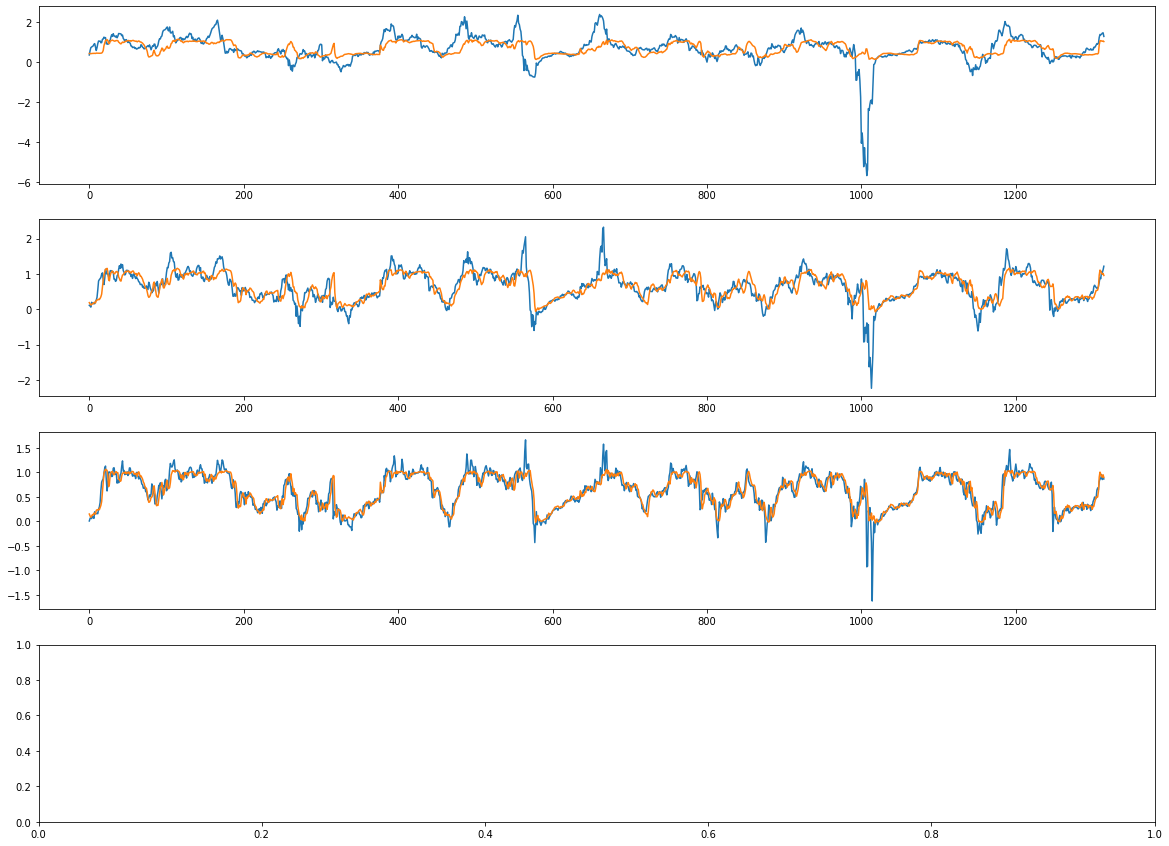

In [124]:
with torch.no_grad():
  
  fig, axs = plt.subplots(len(models))
  fig.set_size_inches(20,15)
  for i in range(len(models)):
    prev = []
    close = []
    for input, output in dataset[i]:
      close.append(output.view(-1,).item())
      prev.append(models[i](input.view(1, seq_length[i], 1).float()).view(-1,).item())
    axs[i].plot(close, label="close")
    axs[i].plot(prev, label="prev")

## Modified Model

In [125]:
class LSTMPrice2(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTMPrice2, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 64)
    self.fc_2 = nn.Linear(64, num_classes)

  def forward(self, x):
    for i in range(self.seq_length):
      h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
      c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
      # Propagate input through LSTM
      output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
      #out = torch.reshape(output, (output.size(0), -1))
      hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
      out = F.relu(hn)
      out = F.relu(self.fc_1(out)) #first Dense
      out = self.fc_2(out) #Final Output


      #Output with sigmoid
      #out = torch.sigmoid(out)
      
      x = torch.cat( (x,out.view(x.size(0), 1, 1)), 1)[:, 1:]

    return out      


In [126]:
dataset = []
dataset.append(PriceDataset(time_window=60, delta_prev=15))
dataset.append(PriceDataset(time_window=60, delta_prev=5))
dataset.append(PriceDataset(time_window=60, delta_prev=1))
dataset.append(PriceDataset(time_window=90, delta_prev=1))

In [127]:
#Hyperparameters
batch_size=32
learning_rate=0.0001
input_size=[dataset[i][0][0].shape[1] for i in range(len(dataset))]
seq_length = [dataset[i][0][0].shape[0] for i in range(len(dataset))]
hidden_size=[10, 10, 20, 20]
num_epochs=200
num_layers=[1, 1, 1, 2]
num_classes=[dataset[i][0][1].shape[0] for i in range(len(dataset))]

In [128]:
train_loaders = []
for i in range(len(dataset)):
  train_loaders.append(DataLoader(dataset=dataset[i],
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2))

In [129]:
models = []
for i in range(len(hidden_size)):
  models.append(LSTMPrice2(num_classes[i], input_size[i], hidden_size[i], num_layers[i], seq_length[i]))

criterion = nn.MSELoss()

optimizer = []
for i in range(len(models)):
  optimizer.append(torch.optim.Adam(models[i].parameters(), lr=learning_rate))

#example_input = dataset1[0][0].view(1,seq_length,1)
#print(example_input)
#model(example_input.float())

In [ ]:
for i in range(len(models)):
  print("Model " + str(i))
  train_loop(models[i], train_loaders[i], num_epochs, criterion, optimizer[i], batch_size)

Model 0
Epoch [1/200], Loss: 0.5271683931350708
Epoch [11/200], Loss: 2.131321430206299
Epoch [21/200], Loss: 0.18502779304981232
Epoch [31/200], Loss: 0.19449807703495026
Epoch [41/200], Loss: 0.3170744478702545
Epoch [51/200], Loss: 0.6006033420562744
Epoch [61/200], Loss: 0.09958197921514511
Epoch [71/200], Loss: 0.8961232304573059
Epoch [81/200], Loss: 0.3038198947906494
Epoch [91/200], Loss: 0.9823079109191895
Epoch [101/200], Loss: 0.10392946004867554
Epoch [111/200], Loss: 0.3378218710422516
Epoch [121/200], Loss: 0.7425762414932251
Epoch [131/200], Loss: 0.24063077569007874
Epoch [141/200], Loss: 0.22431808710098267
Epoch [151/200], Loss: 0.28016960620880127
Epoch [161/200], Loss: 0.2132348120212555
Epoch [171/200], Loss: 0.2581622898578644
Epoch [181/200], Loss: 0.11960546672344208
Epoch [191/200], Loss: 0.45273372530937195
Model 1
Epoch [1/200], Loss: 0.7837322354316711
Epoch [11/200], Loss: 0.23952895402908325
Epoch [21/200], Loss: 0.10166466981172562
Epoch [31/200], Loss: 0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

KeyboardInterrupt: ignored

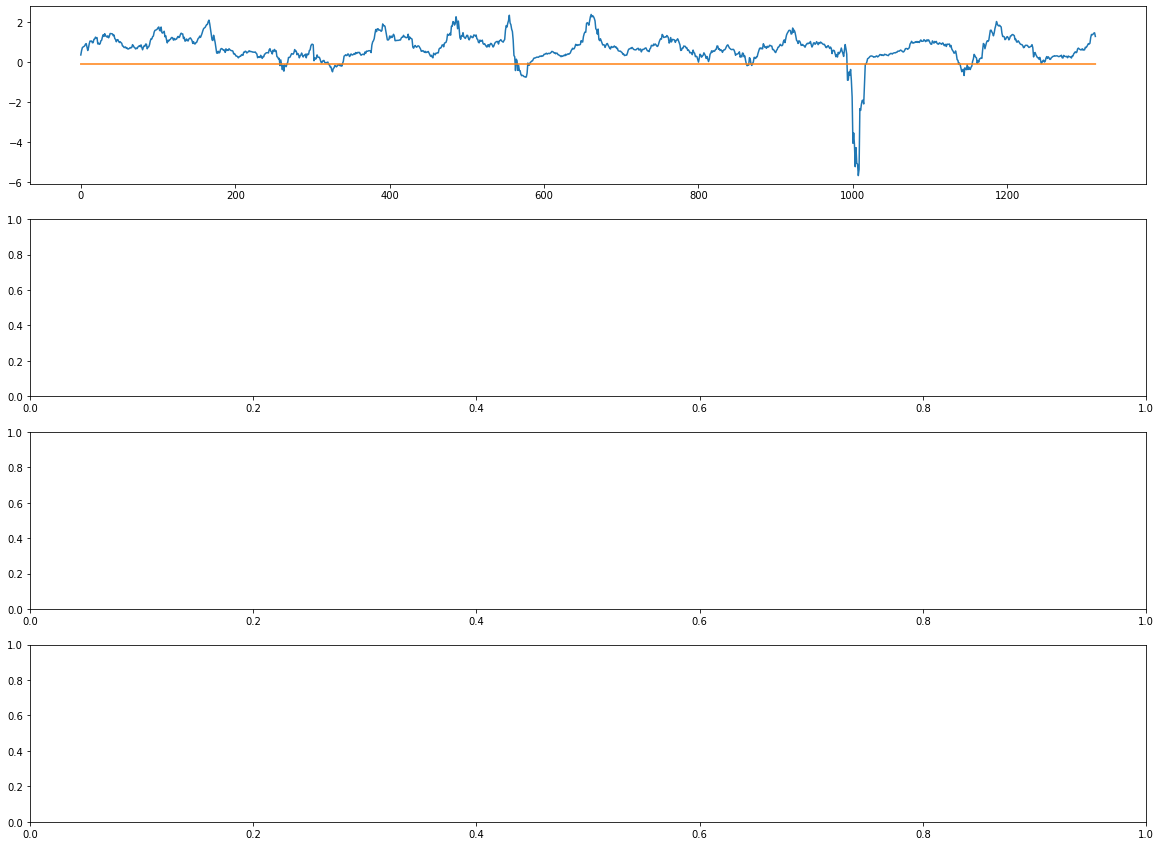

In [130]:
with torch.no_grad():
  
  fig, axs = plt.subplots(len(models))
  fig.set_size_inches(20,15)
  for i in range(len(models)):
    prev = []
    close = []
    for input, output in dataset[i]:
      close.append(output.view(-1,).item())
      prev.append(models[i](input.view(1, seq_length[i], 1).float()).view(-1,).item())
    axs[i].plot(close, label="close")
    axs[i].plot(prev, label="prev")

## Model 3

In [ ]:
class LSTMPrice3(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTMPrice3, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size*seq_length, 64)
    self.fc_2 = nn.Linear(64, num_classes)

  def forward(self, x):
    #for i in range(self.seq_length):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #hidden state
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) #internal state
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    out = torch.reshape(output, (output.size(0), -1))
    #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = F.relu(out)
    out = F.relu(self.fc_1(out)) #first Dense
    out = self.fc_2(out) #Final Output


    #Output with sigmoid
    #out = torch.sigmoid(out)
      
      #x = torch.cat( (x,out.view(x.size(0), 1, 1)), 1)[:, 1:]

    return out      
